<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

<h1 style="color:#006400">Tools</h1>

<h1 style="color:#FF5733 ; font-size:15px"> CommPy</h1> is an open source toolkit implementing digital communications algorithms in Python using NumPy and SciPy.

In [25]:
pip install scikit-commpy

Note: you may need to restart the kernel to use updated packages.


<h1 style="color:#006400">Libraries</h1>

In [19]:
from statistics import mean
import numpy as np
from numpy.random import *
from numpy import *
from numpy.linalg import inv
from commpy.utilities import *
from commpy.modulation import QAMModem
from commpy.channels import *
from commpy.links import *
from math import *
import matplotlib.pyplot as plt
import time 

<h1 style="color:#006400">Functions</h1>

### 1. High Power Amplifier Output  

In [20]:
def hpa_sspa_modif_rapp(vin,Vsat,p,q,G,A,B):
    A=-345
    a0=abs(vin)
    theta=np.angle(vin)
    Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
    Bm=(A*(a0**q))/((1+(a0/B)**(q)))
    vout=Am*np.exp(1j*(theta+Bm))
    return(vout)
    

### 2. Non Linear Distortion Parameters  

In [21]:
def find_K0_sigma2_d(vin,vout):
    K0 = np.mean(vout*np.conj(vin))/np.mean(np.absolute(vin)**2)
    sigma2_d = np.var(vout - K0*vin)
    return(K0,sigma2_d)

<h1 style="color:#006400">Basic PA Non linear Distortion Model </h1>

In [23]:
IBO=1
p=1.1
q=4
Vsat=1.9
G=16
A=-345
B=0.17
val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt(10**(-IBO/10))
s=np.random.randn(1,1000000)
vin1 = np.sqrt(1/2)*(s+1j*s)
vin01 = coeff_IBO_m1dB*vin1
a0=np.absolute(vin01)
a02=a0**2  
theta=np.angle(vin01)
Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
Bm=(A*(a0**q))/((1+(a0/B)**(q)))
Sm=Am*np.exp(1j*(Bm))
vout1=Am*np.exp(1j*(theta+Bm))
K0 = np.mean(vout1*np.conj(vin01))/np.mean(np.absolute(vin01)**2)
sigma2_d = np.var(vout1 - K0*vin01) 
print(K0)
print(sigma2_d)

(12.80593467475129-0.4431250960349492j)
0.013511980651175311


<h1 style="color:#006400">Training Dataset </h1>

Generate 1000 H; 
For each H, we have 5000 S (input of NN1) and 5000 X_gd (output of NN1)

In [24]:
Mr=10
Mt=100
M=16
SNRdb=600
N_bits=Mr*np.log2(M)
MSE=np.zeros((Mt,50))
x_gd_amp0=np.zeros((Mt,1))
y_gd_r0=np.zeros([Mt,100])
PAPR_GD=np.zeros((Mt,1))
MUIgdi= np.zeros((Mt,1))
SERgdi=np.zeros((Mt,1))
BERgdi=np.zeros((Mt,1))
GD_Execution_time=0
HH=np.zeros((1,2000))
S=np.zeros((11000,20))
ZZ=np.zeros((11000,10),dtype=complex)
Niter=50
mu1=0.0022
lamda=0.00071
mu2=1
eps=1e-2
x_gd=np.zeros([Mt,1])
X_gd=np.zeros((11000,100))
gdx1=np.zeros([Mt,Niter])
d=np.zeros([Mt,1])
X=np.zeros((11000,200))
H=(1/np.sqrt(2*Mt))*(np.random.randn(Mr,Mt)+1j*np.random.randn(Mr,Mt))
HR=H.flatten()
realh=np.real(HR)
imagh=np.imag(HR)
Hr=np.concatenate((realh,imagh),axis=0).reshape(-1,1)
Hr=np.reshape(Hr, (2000, 1)).T
HH=Hr
for j in range(11000):
    bits = np.random.randint(2, size=int(N_bits))
    QAM16 = QAMModem(16)
    z=QAM16.modulate(bits)
    Z = np.reshape(z, (1, 10)).T
    ZZ[j]=Z.T
    reals=np.real(Z.T)
    imags=np.imag(Z.T)
    s=np.concatenate((reals,imags),axis=1)
    S[j]=s
    ## CDm algo
    for i in range(Niter):
        gdx1=2*np.conj(K0*np.transpose(H)).dot(K0*H.dot(x_gd)+H.dot(d)-Z)
        x_gd=x_gd-mu1*gdx1
        realx=np.real( x_gd)
        imagx=np.imag( x_gd)
        x_z=np.concatenate((realx,imagx),axis=0).T
        X[j]=x_z
        ## HPA 
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(x_gd)))*np.sqrt(10**(-IBO/10))
        vin2=coeff_IBO_m1dB*x_gd
        vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
        K0,sigma2_d=find_K0_sigma2_d (vin2,vout2)
        d=vout2-K0*vin2
        y_gd =np.array(vout2/coeff_IBO_m1dB)      

<h1 style="color:#006400"> Data Normalization </h1>

In [25]:

X_train=S[:8000,:]
y_train=X[:8000,:]
X_test=S[8000:,:]
y_test=X[8000:,:] 

from sklearn.preprocessing import MinMaxScaler
MM =  MinMaxScaler()
X_trains=MM.fit_transform(X_train)
y_trains=MM.fit_transform(y_train)
X_tests=MM.fit_transform(X_test)
y_tests=MM.fit_transform(y_test)

<h1 style="color:#006400"> Artifical Neural Network</h1>

Here owr neural network NN1 for each H
<h1 style="color:#191970; font-size:14px">Input:</h1> 1000 S
<h1 style="color:#191970; font-size:14px">Output:</h1>1000 X_gd
<h1 style="color:#191970; font-size:14px">The activation function selu 'Scaled Exponential Linear' is used for Self-Normalizing Neural Networks </h1>

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, BatchNormalization
import matplotlib.pyplot as plt
model = Sequential()
keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.1, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
keras.optimizers.Adamax(learning_rate=0.9, beta_1=0.999, beta_2=0.999)
model.add(Dense(units =32, kernel_initializer = 'uniform', activation = 'tanh', input_dim =20))
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'selu'))
model.compile(optimizer = 'Adamax', loss = 'mse', metrics = ['accuracy'])
history =model.fit(X_trains, y_trains,validation_data=(X_tests, y_tests), batch_size=1000, epochs=2000,shuffle=False)


Train on 8000 samples, validate on 3000 samples
Epoch 1/2000
8000/8000 [==============================] - 1s 183us/step - loss: 0.2450 - accuracy: 0.0054 - val_loss: 0.2048 - val_accuracy: 0.0057
Epoch 2/2000
8000/8000 [==============================] - 0s 17us/step - loss: 0.1548 - accuracy: 0.0069 - val_loss: 0.0934 - val_accuracy: 0.0063
Epoch 3/2000
8000/8000 [==============================] - 0s 14us/step - loss: 0.0527 - accuracy: 0.0069 - val_loss: 0.0310 - val_accuracy: 0.0063
Epoch 4/2000
8000/8000 [==============================] - 0s 14us/step - loss: 0.0336 - accuracy: 0.0069 - val_loss: 0.0400 - val_accuracy: 0.0050
Epoch 5/2000
8000/8000 [==============================] - 0s 15us/step - loss: 0.0320 - accuracy: 0.0064 - val_loss: 0.0289 - val_accuracy: 0.0040
Epoch 6/2000
8000/8000 [==============================] - 0s 12us/step - loss: 0.0258 - accuracy: 0.0099 - val_loss: 0.0296 - val_accuracy: 0.0083
Epoch 7/2000
8000/8000 [==============================] - 0s 14us/ste

8000/8000 [==============================] - 0s 12us/step - loss: 0.0211 - accuracy: 0.0771 - val_loss: 0.0239 - val_accuracy: 0.0540
Epoch 57/2000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0210 - accuracy: 0.0805 - val_loss: 0.0238 - val_accuracy: 0.0563
Epoch 58/2000
8000/8000 [==============================] - 0s 11us/step - loss: 0.0209 - accuracy: 0.0845 - val_loss: 0.0236 - val_accuracy: 0.0587
Epoch 59/2000
8000/8000 [==============================] - 0s 15us/step - loss: 0.0207 - accuracy: 0.0868 - val_loss: 0.0235 - val_accuracy: 0.0600
Epoch 60/2000
8000/8000 [==============================] - 0s 12us/step - loss: 0.0206 - accuracy: 0.0906 - val_loss: 0.0234 - val_accuracy: 0.0613
Epoch 61/2000
8000/8000 [==============================] - 0s 12us/step - loss: 0.0204 - accuracy: 0.0935 - val_loss: 0.0232 - val_accuracy: 0.0633
Epoch 62/2000
8000/8000 [==============================] - 0s 14us/step - loss: 0.0203 - accuracy: 0.0972 - val_loss: 0.0230 -

8000/8000 [==============================] - 0s 12us/step - loss: 0.0099 - accuracy: 0.2565 - val_loss: 0.0120 - val_accuracy: 0.1950
Epoch 112/2000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0096 - accuracy: 0.2621 - val_loss: 0.0117 - val_accuracy: 0.1997
Epoch 113/2000
8000/8000 [==============================] - 0s 14us/step - loss: 0.0094 - accuracy: 0.2675 - val_loss: 0.0115 - val_accuracy: 0.2043
Epoch 114/2000
8000/8000 [==============================] - 0s 12us/step - loss: 0.0092 - accuracy: 0.2735 - val_loss: 0.0112 - val_accuracy: 0.2100
Epoch 115/2000
8000/8000 [==============================] - 0s 14us/step - loss: 0.0090 - accuracy: 0.2799 - val_loss: 0.0110 - val_accuracy: 0.2130
Epoch 116/2000
8000/8000 [==============================] - 0s 13us/step - loss: 0.0087 - accuracy: 0.2871 - val_loss: 0.0108 - val_accuracy: 0.2197
Epoch 117/2000
8000/8000 [==============================] - 0s 11us/step - loss: 0.0085 - accuracy: 0.2940 - val_loss: 0.

8000/8000 [==============================] - 0s 15us/step - loss: 0.0015 - accuracy: 0.6459 - val_loss: 0.0029 - val_accuracy: 0.4817
Epoch 167/2000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0014 - accuracy: 0.6549 - val_loss: 0.0028 - val_accuracy: 0.4880
Epoch 168/2000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0013 - accuracy: 0.6636 - val_loss: 0.0027 - val_accuracy: 0.4943
Epoch 169/2000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0013 - accuracy: 0.6700 - val_loss: 0.0027 - val_accuracy: 0.4960
Epoch 170/2000
8000/8000 [==============================] - 0s 12us/step - loss: 0.0012 - accuracy: 0.6770 - val_loss: 0.0026 - val_accuracy: 0.5020
Epoch 171/2000
8000/8000 [==============================] - 0s 16us/step - loss: 0.0011 - accuracy: 0.6862 - val_loss: 0.0025 - val_accuracy: 0.5057
Epoch 172/2000
8000/8000 [==============================] - 0s 10us/step - loss: 0.0011 - accuracy: 0.6935 - val_loss: 0.

Epoch 220/2000
8000/8000 [==============================] - 0s 12us/step - loss: 9.8831e-05 - accuracy: 0.9076 - val_loss: 0.0014 - val_accuracy: 0.5930
Epoch 221/2000
8000/8000 [==============================] - 0s 11us/step - loss: 9.5501e-05 - accuracy: 0.9087 - val_loss: 0.0014 - val_accuracy: 0.5933
Epoch 222/2000
8000/8000 [==============================] - 0s 14us/step - loss: 9.2388e-05 - accuracy: 0.9106 - val_loss: 0.0014 - val_accuracy: 0.5933
Epoch 223/2000
8000/8000 [==============================] - 0s 10us/step - loss: 8.9478e-05 - accuracy: 0.9111 - val_loss: 0.0014 - val_accuracy: 0.5933
Epoch 224/2000
8000/8000 [==============================] - 0s 10us/step - loss: 8.6759e-05 - accuracy: 0.9125 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 225/2000
8000/8000 [==============================] - 0s 11us/step - loss: 8.4220e-05 - accuracy: 0.9137 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 226/2000
8000/8000 [==============================] - 0s 13us/step - loss: 8

8000/8000 [==============================] - 0s 15us/step - loss: 4.9573e-05 - accuracy: 0.9390 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 274/2000
8000/8000 [==============================] - 0s 11us/step - loss: 4.9430e-05 - accuracy: 0.9396 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 275/2000
8000/8000 [==============================] - 0s 12us/step - loss: 4.9290e-05 - accuracy: 0.9398 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 276/2000
8000/8000 [==============================] - 0s 13us/step - loss: 4.9155e-05 - accuracy: 0.9396 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 277/2000
8000/8000 [==============================] - 0s 12us/step - loss: 4.9023e-05 - accuracy: 0.9396 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 278/2000
8000/8000 [==============================] - 0s 12us/step - loss: 4.8893e-05 - accuracy: 0.9398 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 279/2000
8000/8000 [==============================] - 0s 11us/step - loss: 4.8767e-05 - acc

8000/8000 [==============================] - 0s 12us/step - loss: 4.4111e-05 - accuracy: 0.9435 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 327/2000
8000/8000 [==============================] - 0s 10us/step - loss: 4.4021e-05 - accuracy: 0.9436 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 328/2000
8000/8000 [==============================] - 0s 10us/step - loss: 4.3931e-05 - accuracy: 0.9435 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 329/2000
8000/8000 [==============================] - 0s 11us/step - loss: 4.3843e-05 - accuracy: 0.9435 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 330/2000
8000/8000 [==============================] - 0s 10us/step - loss: 4.3756e-05 - accuracy: 0.9435 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 331/2000
8000/8000 [==============================] - 0s 10us/step - loss: 4.3669e-05 - accuracy: 0.9435 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 332/2000
8000/8000 [==============================] - 0s 12us/step - loss: 4.3584e-05 - acc

8000/8000 [==============================] - 0s 12us/step - loss: 4.0013e-05 - accuracy: 0.9455 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 380/2000
8000/8000 [==============================] - 0s 10us/step - loss: 3.9943e-05 - accuracy: 0.9456 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 381/2000
8000/8000 [==============================] - 0s 14us/step - loss: 3.9873e-05 - accuracy: 0.9459 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 382/2000
8000/8000 [==============================] - 0s 18us/step - loss: 3.9803e-05 - accuracy: 0.9459 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 383/2000
8000/8000 [==============================] - 0s 11us/step - loss: 3.9734e-05 - accuracy: 0.9457 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 384/2000
8000/8000 [==============================] - 0s 11us/step - loss: 3.9664e-05 - accuracy: 0.9460 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 385/2000
8000/8000 [==============================] - 0s 11us/step - loss: 3.9595e-05 - acc

8000/8000 [==============================] - 0s 12us/step - loss: 3.6452e-05 - accuracy: 0.9467 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 433/2000
8000/8000 [==============================] - 0s 10us/step - loss: 3.6388e-05 - accuracy: 0.9469 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 434/2000
8000/8000 [==============================] - 0s 12us/step - loss: 3.6324e-05 - accuracy: 0.9469 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 435/2000
8000/8000 [==============================] - 0s 13us/step - loss: 3.6261e-05 - accuracy: 0.9466 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 436/2000
8000/8000 [==============================] - 0s 10us/step - loss: 3.6197e-05 - accuracy: 0.9466 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 437/2000
8000/8000 [==============================] - 0s 10us/step - loss: 3.6133e-05 - accuracy: 0.9466 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 438/2000
8000/8000 [==============================] - 0s 13us/step - loss: 3.6068e-05 - acc

8000/8000 [==============================] - 0s 12us/step - loss: 3.2845e-05 - accuracy: 0.9470 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 486/2000
8000/8000 [==============================] - 0s 11us/step - loss: 3.2775e-05 - accuracy: 0.9473 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 487/2000
8000/8000 [==============================] - 0s 10us/step - loss: 3.2705e-05 - accuracy: 0.9471 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 488/2000
8000/8000 [==============================] - 0s 10us/step - loss: 3.2635e-05 - accuracy: 0.9467 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 489/2000
8000/8000 [==============================] - 0s 13us/step - loss: 3.2565e-05 - accuracy: 0.9470 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 490/2000
8000/8000 [==============================] - 0s 12us/step - loss: 3.2495e-05 - accuracy: 0.9474 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 491/2000
8000/8000 [==============================] - 0s 10us/step - loss: 3.2425e-05 - acc

8000/8000 [==============================] - 0s 12us/step - loss: 2.9687e-05 - accuracy: 0.9485 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 539/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.9637e-05 - accuracy: 0.9486 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 540/2000
8000/8000 [==============================] - 0s 13us/step - loss: 2.9598e-05 - accuracy: 0.9488 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 541/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.9553e-05 - accuracy: 0.9486 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 542/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.9495e-05 - accuracy: 0.9489 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 543/2000
8000/8000 [==============================] - 0s 11us/step - loss: 2.9459e-05 - accuracy: 0.9488 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 544/2000
8000/8000 [==============================] - 0s 15us/step - loss: 2.9411e-05 - acc

8000/8000 [==============================] - 0s 13us/step - loss: 2.6729e-05 - accuracy: 0.9500 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 592/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.6871e-05 - accuracy: 0.9504 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 593/2000
8000/8000 [==============================] - 0s 11us/step - loss: 2.6942e-05 - accuracy: 0.9503 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 594/2000
8000/8000 [==============================] - 0s 14us/step - loss: 2.6718e-05 - accuracy: 0.9504 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 595/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.6103e-05 - accuracy: 0.9506 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 596/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.5799e-05 - accuracy: 0.9505 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 597/2000
8000/8000 [==============================] - 0s 11us/step - loss: 2.5858e-05 - acc

8000/8000 [==============================] - 0s 12us/step - loss: 2.4540e-05 - accuracy: 0.9523 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 645/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.4041e-05 - accuracy: 0.9525 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 646/2000
8000/8000 [==============================] - 0s 11us/step - loss: 2.3508e-05 - accuracy: 0.9519 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 647/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.3420e-05 - accuracy: 0.9520 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 648/2000
8000/8000 [==============================] - 0s 15us/step - loss: 2.3538e-05 - accuracy: 0.9520 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 649/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.3677e-05 - accuracy: 0.9519 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 650/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.3789e-05 - acc

8000/8000 [==============================] - 0s 12us/step - loss: 2.1707e-05 - accuracy: 0.9542 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 698/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.1838e-05 - accuracy: 0.9542 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 699/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.1974e-05 - accuracy: 0.9539 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 700/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.2103e-05 - accuracy: 0.9541 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 701/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.2254e-05 - accuracy: 0.9541 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 702/2000
8000/8000 [==============================] - 0s 13us/step - loss: 2.2440e-05 - accuracy: 0.9539 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 703/2000
8000/8000 [==============================] - 0s 13us/step - loss: 2.2491e-05 - acc

8000/8000 [==============================] - 0s 11us/step - loss: 2.0520e-05 - accuracy: 0.9550 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 751/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.0214e-05 - accuracy: 0.9551 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 752/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.0165e-05 - accuracy: 0.9553 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 753/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.0250e-05 - accuracy: 0.9554 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 754/2000
8000/8000 [==============================] - 0s 12us/step - loss: 2.0388e-05 - accuracy: 0.9555 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 755/2000
8000/8000 [==============================] - 0s 10us/step - loss: 2.0548e-05 - accuracy: 0.9560 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 756/2000
8000/8000 [==============================] - 0s 12us/step - loss: 2.0730e-05 - acc

8000/8000 [==============================] - 0s 13us/step - loss: 1.9758e-05 - accuracy: 0.9557 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 804/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.9423e-05 - accuracy: 0.9560 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 805/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.9142e-05 - accuracy: 0.9557 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 806/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.9056e-05 - accuracy: 0.9557 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 807/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.9101e-05 - accuracy: 0.9556 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 808/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.9218e-05 - accuracy: 0.9557 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 809/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.9379e-05 - acc

8000/8000 [==============================] - 0s 11us/step - loss: 1.8489e-05 - accuracy: 0.9560 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 857/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.8357e-05 - accuracy: 0.9560 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 858/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.8347e-05 - accuracy: 0.9564 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 859/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.8431e-05 - accuracy: 0.9563 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 860/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.8571e-05 - accuracy: 0.9566 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 861/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.8723e-05 - accuracy: 0.9569 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 862/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.8789e-05 - acc

8000/8000 [==============================] - 0s 15us/step - loss: 1.7842e-05 - accuracy: 0.9567 - val_loss: 0.0013 - val_accuracy: 0.5930
Epoch 910/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.7962e-05 - accuracy: 0.9564 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 911/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.8028e-05 - accuracy: 0.9569 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 912/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.8045e-05 - accuracy: 0.9569 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 913/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.8027e-05 - accuracy: 0.9569 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 914/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.7931e-05 - accuracy: 0.9566 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 915/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.7795e-05 - acc

8000/8000 [==============================] - 0s 11us/step - loss: 1.7290e-05 - accuracy: 0.9565 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 963/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.7373e-05 - accuracy: 0.9564 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 964/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.7424e-05 - accuracy: 0.9569 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 965/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.7434e-05 - accuracy: 0.9567 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 966/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.7428e-05 - accuracy: 0.9569 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 967/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.7382e-05 - accuracy: 0.9567 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 968/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.7310e-05 - acc

8000/8000 [==============================] - 0s 11us/step - loss: 1.6987e-05 - accuracy: 0.9565 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1016/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.6981e-05 - accuracy: 0.9565 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1017/2000
8000/8000 [==============================] - 0s 16us/step - loss: 1.6972e-05 - accuracy: 0.9564 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1018/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.6962e-05 - accuracy: 0.9564 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1019/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.6950e-05 - accuracy: 0.9563 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1020/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.6939e-05 - accuracy: 0.9566 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1021/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.6929e-05

8000/8000 [==============================] - 0s 12us/step - loss: 1.6527e-05 - accuracy: 0.9571 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1069/2000
8000/8000 [==============================] - 0s 47us/step - loss: 1.6530e-05 - accuracy: 0.9569 - val_loss: 0.0013 - val_accuracy: 0.5963
Epoch 1070/2000
8000/8000 [==============================] - 0s 38us/step - loss: 1.6526e-05 - accuracy: 0.9570 - val_loss: 0.0013 - val_accuracy: 0.5967
Epoch 1071/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.6518e-05 - accuracy: 0.9569 - val_loss: 0.0013 - val_accuracy: 0.5963
Epoch 1072/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.6505e-05 - accuracy: 0.9575 - val_loss: 0.0013 - val_accuracy: 0.5963
Epoch 1073/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.6490e-05 - accuracy: 0.9571 - val_loss: 0.0013 - val_accuracy: 0.5963
Epoch 1074/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.6484e-05

8000/8000 [==============================] - 0s 14us/step - loss: 1.5733e-05 - accuracy: 0.9585 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1122/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5759e-05 - accuracy: 0.9588 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1123/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5809e-05 - accuracy: 0.9588 - val_loss: 0.0013 - val_accuracy: 0.5963
Epoch 1124/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.5850e-05 - accuracy: 0.9588 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1125/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5812e-05 - accuracy: 0.9595 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1126/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5898e-05 - accuracy: 0.9594 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1127/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5885e-05

8000/8000 [==============================] - 0s 12us/step - loss: 1.5773e-05 - accuracy: 0.9591 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1175/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5336e-05 - accuracy: 0.9604 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1176/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.5289e-05 - accuracy: 0.9604 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1177/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.5715e-05 - accuracy: 0.9596 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1178/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5506e-05 - accuracy: 0.9596 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 1179/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5319e-05 - accuracy: 0.9592 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1180/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.5286e-05

8000/8000 [==============================] - 0s 12us/step - loss: 1.5186e-05 - accuracy: 0.9606 - val_loss: 0.0013 - val_accuracy: 0.5933
Epoch 1228/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.5075e-05 - accuracy: 0.9599 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1229/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.5030e-05 - accuracy: 0.9600 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1230/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5089e-05 - accuracy: 0.9604 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1231/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5088e-05 - accuracy: 0.9604 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 1232/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.5230e-05 - accuracy: 0.9604 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1233/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5593e-05

8000/8000 [==============================] - 0s 11us/step - loss: 1.4959e-05 - accuracy: 0.9605 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1281/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.5019e-05 - accuracy: 0.9611 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1282/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.5341e-05 - accuracy: 0.9610 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1283/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.5096e-05 - accuracy: 0.9605 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1284/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4959e-05 - accuracy: 0.9601 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1285/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.4865e-05 - accuracy: 0.9603 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1286/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.4880e-05

8000/8000 [==============================] - 0s 12us/step - loss: 1.4821e-05 - accuracy: 0.9606 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1334/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4831e-05 - accuracy: 0.9601 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1335/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4858e-05 - accuracy: 0.9599 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1336/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4901e-05 - accuracy: 0.9601 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1337/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.5002e-05 - accuracy: 0.9605 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1338/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.5064e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 1339/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4991e-05

8000/8000 [==============================] - 0s 13us/step - loss: 1.5016e-05 - accuracy: 0.9605 - val_loss: 0.0013 - val_accuracy: 0.5967
Epoch 1387/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.4843e-05 - accuracy: 0.9611 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 1388/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.5020e-05 - accuracy: 0.9604 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1389/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.4795e-05 - accuracy: 0.9613 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1390/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.4637e-05 - accuracy: 0.9613 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1391/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.4612e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1392/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4599e-05

8000/8000 [==============================] - 0s 15us/step - loss: 1.4586e-05 - accuracy: 0.9609 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1440/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4500e-05 - accuracy: 0.9606 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1441/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4530e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1442/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.4546e-05 - accuracy: 0.9611 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1443/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.4539e-05 - accuracy: 0.9613 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1444/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.4549e-05 - accuracy: 0.9613 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1445/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.4575e-05

8000/8000 [==============================] - 0s 10us/step - loss: 1.4617e-05 - accuracy: 0.9606 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 1493/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.4412e-05 - accuracy: 0.9615 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1494/2000
8000/8000 [==============================] - 0s 18us/step - loss: 1.4487e-05 - accuracy: 0.9605 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1495/2000
8000/8000 [==============================] - 0s 18us/step - loss: 1.4605e-05 - accuracy: 0.9606 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 1496/2000
8000/8000 [==============================] - 0s 18us/step - loss: 1.4628e-05 - accuracy: 0.9609 - val_loss: 0.0013 - val_accuracy: 0.5933
Epoch 1497/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.4738e-05 - accuracy: 0.9614 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1498/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4547e-05

8000/8000 [==============================] - 0s 16us/step - loss: 1.4714e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1546/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4437e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 1547/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4283e-05 - accuracy: 0.9609 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 1548/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4246e-05 - accuracy: 0.9609 - val_loss: 0.0013 - val_accuracy: 0.5963
Epoch 1549/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.4253e-05 - accuracy: 0.9609 - val_loss: 0.0013 - val_accuracy: 0.5963
Epoch 1550/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4268e-05 - accuracy: 0.9614 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1551/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4342e-05 

8000/8000 [==============================] - 0s 12us/step - loss: 1.4188e-05 - accuracy: 0.9611 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1599/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4219e-05 - accuracy: 0.9611 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1600/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4258e-05 - accuracy: 0.9605 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1601/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.4297e-05 - accuracy: 0.9600 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1602/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4342e-05 - accuracy: 0.9600 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1603/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4366e-05 - accuracy: 0.9601 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1604/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4400e-05 - a

8000/8000 [==============================] - 0s 10us/step - loss: 1.4193e-05 - accuracy: 0.9599 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1652/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4224e-05 - accuracy: 0.9604 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1653/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4149e-05 - accuracy: 0.9605 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 1654/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4210e-05 - accuracy: 0.9603 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1655/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.4415e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1656/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4377e-05 - accuracy: 0.9601 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1657/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4106e-05 - a

8000/8000 [==============================] - 0s 12us/step - loss: 1.4131e-05 - accuracy: 0.9616 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1705/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4199e-05 - accuracy: 0.9611 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 1706/2000
8000/8000 [==============================] - 0s 15us/step - loss: 1.4485e-05 - accuracy: 0.9613 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1707/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4171e-05 - accuracy: 0.9616 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1708/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4090e-05 - accuracy: 0.9614 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1709/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4388e-05 - accuracy: 0.9603 - val_loss: 0.0013 - val_accuracy: 0.5933
Epoch 1710/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4239e-05 - 

8000/8000 [==============================] - 0s 9us/step - loss: 1.4115e-05 - accuracy: 0.9603 - val_loss: 0.0013 - val_accuracy: 0.5970
Epoch 1758/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4195e-05 - accuracy: 0.9615 - val_loss: 0.0013 - val_accuracy: 0.5963
Epoch 1759/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4363e-05 - accuracy: 0.9617 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 1760/2000
8000/8000 [==============================] - 0s 10us/step - loss: 1.4158e-05 - accuracy: 0.9614 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1761/2000
8000/8000 [==============================] - 0s 38us/step - loss: 1.4127e-05 - accuracy: 0.9616 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1762/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.4327e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1763/2000
8000/8000 [==============================] - 0s 9us/step - loss: 1.4026e-05 - 

8000/8000 [==============================] - 0s 40us/step - loss: 1.4007e-05 - accuracy: 0.9616 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1811/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.4081e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1812/2000
8000/8000 [==============================] - 0s 17us/step - loss: 1.4159e-05 - accuracy: 0.9607 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1813/2000
8000/8000 [==============================] - 0s 19us/step - loss: 1.4171e-05 - accuracy: 0.9613 - val_loss: 0.0013 - val_accuracy: 0.5943
Epoch 1814/2000
8000/8000 [==============================] - 0s 24us/step - loss: 1.4232e-05 - accuracy: 0.9614 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1815/2000
8000/8000 [==============================] - 0s 19us/step - loss: 1.4329e-05 - accuracy: 0.9609 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1816/2000
8000/8000 [==============================] - 0s 23us/step - loss: 1.4190e-05

8000/8000 [==============================] - 0s 12us/step - loss: 1.4258e-05 - accuracy: 0.9622 - val_loss: 0.0013 - val_accuracy: 0.5940
Epoch 1864/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.3991e-05 - accuracy: 0.9619 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1865/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.3897e-05 - accuracy: 0.9620 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1866/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.4222e-05 - accuracy: 0.9621 - val_loss: 0.0013 - val_accuracy: 0.5937
Epoch 1867/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.4170e-05 - accuracy: 0.9620 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1868/2000
8000/8000 [==============================] - 0s 15us/step - loss: 1.4055e-05 - accuracy: 0.9614 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1869/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.4004e-05

8000/8000 [==============================] - 0s 13us/step - loss: 1.3864e-05 - accuracy: 0.9614 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1917/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.3823e-05 - accuracy: 0.9610 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1918/2000
8000/8000 [==============================] - 0s 15us/step - loss: 1.3828e-05 - accuracy: 0.9609 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1919/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.3840e-05 - accuracy: 0.9606 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 1920/2000
8000/8000 [==============================] - 0s 11us/step - loss: 1.3886e-05 - accuracy: 0.9610 - val_loss: 0.0013 - val_accuracy: 0.5960
Epoch 1921/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.3916e-05 - accuracy: 0.9613 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1922/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.3978e-05

8000/8000 [==============================] - 0s 17us/step - loss: 1.3816e-05 - accuracy: 0.9620 - val_loss: 0.0013 - val_accuracy: 0.5957
Epoch 1970/2000
8000/8000 [==============================] - 0s 14us/step - loss: 1.3829e-05 - accuracy: 0.9622 - val_loss: 0.0013 - val_accuracy: 0.5947
Epoch 1971/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.3832e-05 - accuracy: 0.9621 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1972/2000
8000/8000 [==============================] - 0s 12us/step - loss: 1.3828e-05 - accuracy: 0.9624 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1973/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.3839e-05 - accuracy: 0.9624 - val_loss: 0.0013 - val_accuracy: 0.5950
Epoch 1974/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.3856e-05 - accuracy: 0.9625 - val_loss: 0.0013 - val_accuracy: 0.5953
Epoch 1975/2000
8000/8000 [==============================] - 0s 13us/step - loss: 1.3891e-05

<h1 style="color:#006400"> Weights Vector of NN1</h1>

In [ ]:
first_layer_weights =model.layers[0].get_weights()[0] 
first=first_layer_weights.flatten()
first_layer_biases  = model.layers[0].get_weights()[1]
first_layer=np.concatenate((first,first_layer_biases),axis=0)
second_layer_weights = model.layers[1].get_weights()[0]
second=second_layer_weights.flatten()
second_layer_biases  = model.layers[1].get_weights()[1]
second_layer=np.concatenate((second,second_layer_biases),axis=0)
weights=np.concatenate((first_layer,second_layer),axis=0)
print (len(weights))

<h1 style="color:#006400"> Make Predictions</h1>

In [31]:
#train set
y_preds = model.predict(X_trains)
y_pred=MM.inverse_transform(y_preds)

#test set 
y_predss = model.predict(X_tests)
y_predt=MM.inverse_transform(y_predss)




<h1 style="color:#006400"> Model Representation</h1>

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

<h1 style="color:#006400"> Accuracy Representation </h1>

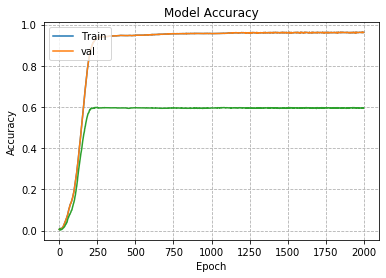

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Loss Representation</h1>

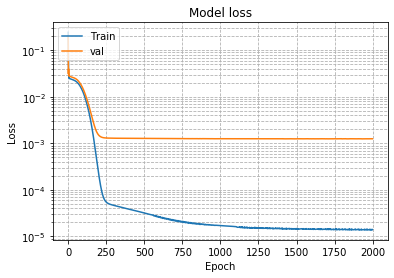

In [33]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Mean-Squared-Error</h1>

# Train Set

Mean Squred Error: -17.67535802041939


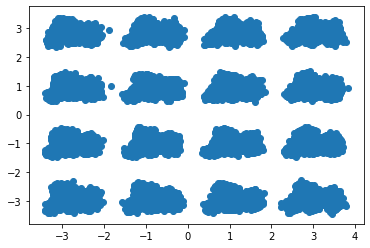

In [34]:
#NMSE_Units=[]
NMSE=np.zeros([5000,1])
recievehh=np.zeros([5000,10],dtype=complex)
Y_gdr=y_pred[:,:100]
Y_gdi=1j*y_pred[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_train[:,:10]
Shi=1j*X_train[:,10:20]
SSh=Shr+Shi
for i in range(5000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd[i]
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(Y_gd_amp)).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(ZZ[i]-recieveh)**2)/np.mean(np.abs(ZZ[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE[i]))
recievehhh=recievehh.flatten()
realr=np.real(recievehhh)
imagr=np.imag(recievehhh)
plt.scatter(realr,imagr)    
print('Mean Squred Error:', NMSEdb)

# Test Set 

Mean Squred Error: -17.894830702656915


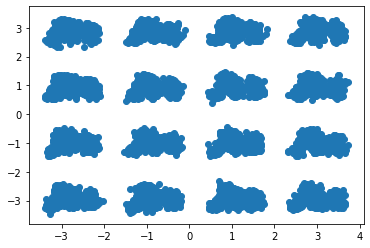

In [35]:
NMSE=np.zeros([1000,1])
recievehh=np.zeros([1000,10],dtype=complex)
Y_gdr=y_predt[:,:100]
Y_gdi=1j*y_predt[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_test[:,:10]
Shi=1j*X_test[:,10:20]
SSh=Shr+Shi
for i in range(1000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd[i]
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(Y_gd_amp)).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(SSh[i]-recieveh)**2)/np.mean(np.abs(SSh[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE[i]))
recievehhh=recievehh.flatten()
realr=np.real(recievehhh)
imagr=np.imag(recievehhh)
plt.scatter(realr,imagr)    
print('Mean Squred Error:', NMSEdb)